<h2>Final DAG Generation</h2>

The learnings from the best of the DAGs we generated with py-tetrad in combination with Thomas's domain expertise allowed us to create a cogent final DAG using networkX, using OLS coefficient magnitudes to generate the stength of the directed edges.

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

BASE_DIR = Path().resolve().parent

In [ ]:
def load_and_preprocess(
    files_path: Path,
    chunk_size: int = 100_000,
    sample_frac: float = 1.0
):
    """
    Loads natality data in chunks, applies optional sampling, converts rf_ and ip_
    columns to numeric, creates aggregate RF/IP indicators, renames columns, and
    returns a numeric DataFrame with Maternal Morbidity as int.
    """
    first_cols = pd.read_csv(files_path, nrows=0, low_memory=False).columns

    ld_cols = [c for c in first_cols if c.lower().startswith("ld_")]
    rf_cols = [c for c in first_cols if c.lower().startswith("rf_")]
    ip_cols = [c for c in first_cols if c.lower().startswith("ip_")]

    usecols = [
        "bmi", "meduc", "feduc", "precare", "previs", "cig_rec",
        "morbidity_reported", "bfacil", "pay", "attend", "me_pres", "me_rout",
        'date'] + ld_cols + rf_cols + ip_cols

    rename_map = {
        "bmi": "Body Mass Index",
        "meduc": "Mother Education",
        "feduc": "Father Education",
        "precare": "Pre-natal Care Begins",
        "previs": "Pre-natal Visits",
        "cig_rec": "Cigarette Smoking",
        "morbidity_reported": "Maternal Morbidity",
        "bfacil": "Facility",
        "pay": "Payment Method",
        "attend": "Medical Provider",
        "ld_indl": "Induction of Labor",
        "ld_augm": "Augmentation of Labor",
        "ld_ster": "Steriods Used",
        "ld_antb": "Antibiotics Used",
        "ld_chor": "Chorioamnionitis Present",
        "ld_anes": "Anesthesia Used",
        "me_pres": "Fetal Presentation at Delivery",
        "me_rout": "Final Route of Delivery",
        "date": "Date of Birth",
    }

    dfs = []
    reader = pd.read_csv(files_path, chunksize=chunk_size, usecols=usecols, low_memory=False)

    for chunk in reader:
        sampled = chunk.sample(frac=sample_frac, random_state=42)

        rf_present = [c for c in rf_cols if c in sampled.columns]
        ip_present = [c for c in ip_cols if c in sampled.columns]

        if rf_present:
            sampled[rf_present] = sampled[rf_present].apply(pd.to_numeric, errors="coerce").fillna(0)
        if ip_present:
            sampled[ip_present] = sampled[ip_present].apply(pd.to_numeric, errors="coerce").fillna(0)

        sampled["Risk Factor Present"] = (sampled[rf_present].sum(axis=1) > 0).astype(int)
        sampled["Infection Present"] = (sampled[ip_present].sum(axis=1) > 0).astype(int)

        sampled.drop(columns=rf_present + ip_present, inplace=True)

        sampled.rename(columns=rename_map, inplace=True)
        dfs.append(sampled)

    df = pd.concat(dfs, ignore_index=True)

    df = df.select_dtypes(include=[np.number]).dropna()
    df["Maternal Morbidity"] = df["Maternal Morbidity"].astype(int)

    return df

In [ ]:
df = load_and_preprocess(BASE_DIR / 'data_main' / "natality_aligned_10pct_sample.csv", sample_frac=0.1)

/tmp/ipython-input-1078396407.py:47: DtypeWarning: Columns (86) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


In [ ]:
def build_dag1():
    G = nx.DiGraph()

    # causal tiers / heierarchy
    tiers = {
        "Pre-Pregnancy": [
            "Body Mass Index",
            "Mother Education",
            "Father Education",
        ],
        "Pregnancy": [
            "Pre-natal Visits",
            "Cigarette Smoking",
            # "Payment Method",
            "Medical Provider",
        ],
        "Intrapartum Exposures": [
            "Augmentation of Labor",
            "Antibiotics Used",
            "Fetal Presentation at Delivery",
        ],
        "Mediators": [
            "Chorioamnionitis Present",
            "Final Route of Delivery",
            "Risk Factor Present",
            "Infection Present",
        ],
        "Outcome": [
            "Maternal Morbidity"
        ]
    }

    # Flatten node list
    nodes = [n for group in tiers.values() for n in group]
    G.add_nodes_from(nodes)

    # edges / relationships
    edges = [
        # Pre-pregnancy -> pregnancy
        ("Body Mass Index", "Pre-natal Visits"),
        ("Mother Education", "Pre-natal Visits"),
        ("Father Education", "Pre-natal Visits"),
        ("Mother Education", "Medical Provider"),
        ("Father Education", "Medical Provider"),
        # ("Mother Education", "Payment Method"),
        # ("Father Education", "Payment Method"),
        ("Body Mass Index", 'Maternal Morbidity'),

        # Pregnancy-> intrapartum exposures
        ("Pre-natal Visits", 'Maternal Morbidity'),
        # ("Pre-natal Visits", "Cigarette Smoking"),
        # ("Pre-natal Visits", "Payment Method"),
        ("Pre-natal Visits", "Medical Provider"),
        ("Pre-natal Visits", "Risk Factor Present"),
        ("Pre-natal Visits", "Infection Present"),
        # ("Pre-natal Visits", "Augmentation of Labor"),
        ("Pre-natal Visits", "Fetal Presentation at Delivery"),
        ("Cigarette Smoking", "Risk Factor Present"),
        ("Cigarette Smoking", "Maternal Morbidity"),
        ("Medical Provider", "Infection Present"),
        ("Medical Provider", "Risk Factor Present"),
        ("Medical Provider", "Fetal Presentation at Delivery"),
        # ("Medical Provider", "Payment Method"),
        # ("Payment Method", "Infection Present"),
        ("Medical Provider", 'Chorioamnionitis Present'),

        # Intrapartum -> mediators / outcome
        ("Augmentation of Labor", 'Maternal Morbidity'),
        ("Fetal Presentation at Delivery", "Maternal Morbidity"),
        ("Antibiotics Used", "Chorioamnionitis Present"),
        ("Antibiotics Used", "Infection Present"),
        ("Augmentation of Labor", "Final Route of Delivery"),
        ("Fetal Presentation at Delivery", "Final Route of Delivery"),

        # Mediators -> outcome
        ("Chorioamnionitis Present", "Maternal Morbidity"),
        ("Final Route of Delivery", "Maternal Morbidity"),
        ("Risk Factor Present", "Maternal Morbidity"),
        ("Infection Present", "Maternal Morbidity"),
    ]
    G.add_edges_from(edges)

    return G, tiers

In [10]:
def compute_edge_strengths(G, df):
    for u, v in G.edges():
        X = df[[u]].values.reshape(-1, 1)
        y = df[v].values
        model = LinearRegression().fit(X, y)
        G[u][v]["weight"] = abs(model.coef_[0])

In [11]:
def plot_weighted_dag(G, tiers):
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    except:
        pos = nx.spring_layout(G, k=1.6, seed=42)

    # Tier coloring as before
    tier_colors = {}
    palette = ["#fde68a", "#bbf7d0", "#bfdbfe", "#e9d5ff", "#fecaca"]
    for color, (tier, nodes) in zip(palette, tiers.items()):
        for n in nodes:
            tier_colors[n] = color

    # Extract & scale weights
    weights = [G[u][v].get("weight", 1.0) for u, v in G.edges()]
    max_w = max(weights)
    widths = [1 + 6*(w/max_w) for w in weights]

    plt.figure(figsize=(18, 12))
    nx.draw(
        G, pos,
        with_labels=True,
        arrowsize=15,
        node_color=[tier_colors[n] for n in G.nodes()],
        node_size=2800,
        width=widths,
        edge_color=weights,
        edge_cmap=plt.cm.plasma,
        font_size=10
    )

    # Edge labels
    edge_labels = {(u, v): f"{G[u][v].get('weight', 1):.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Tiered & Weighted Causal DAG", fontsize=18)
    plt.show()


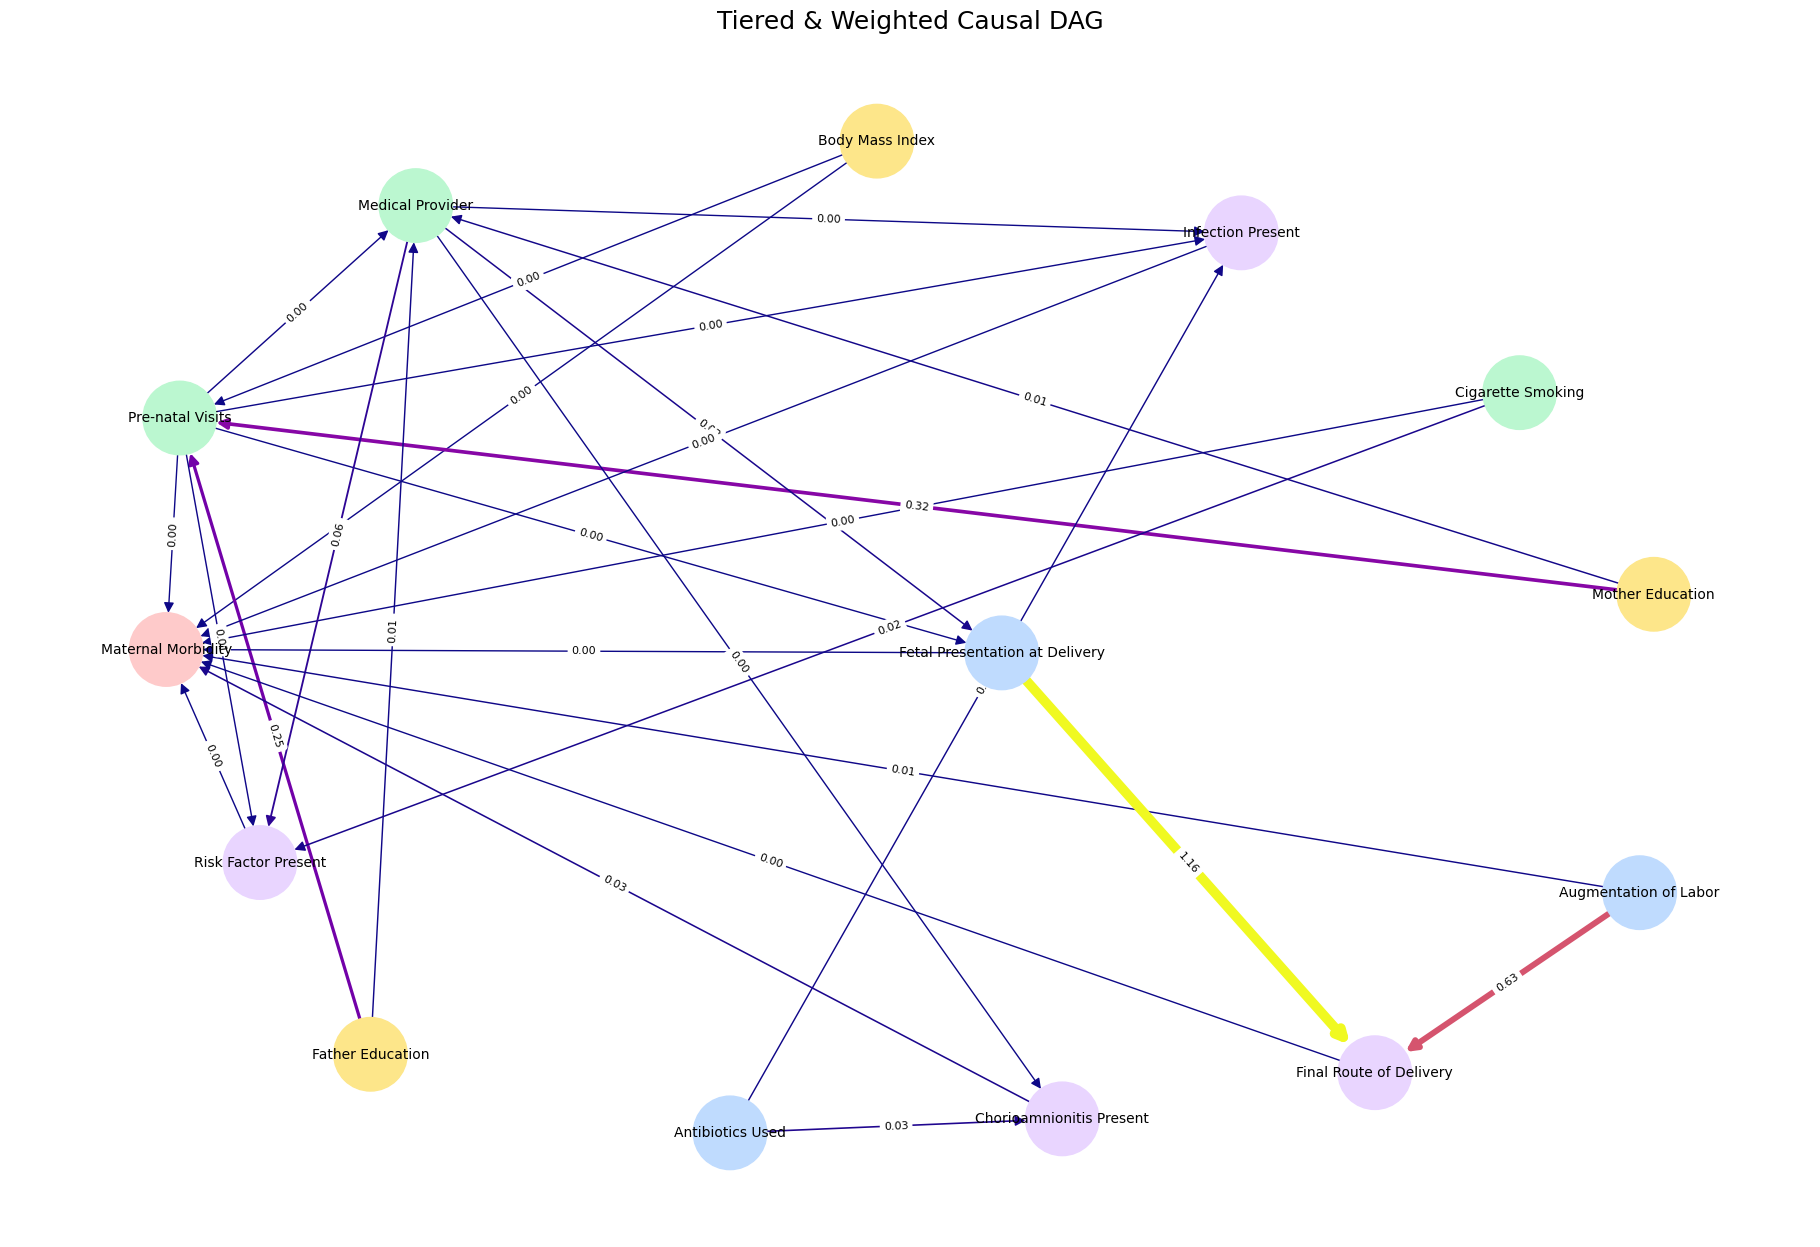

In [12]:
G, tiers = build_dag1()
compute_edge_strengths(G, df)
plot_weighted_dag(G, tiers)

In [ ]:
def build_dag2():
    G = nx.DiGraph()

    # causal tiers / heierarchy
    tiers = {
        "Pre-Pregnancy": [
            "Body Mass Index",
            # "Mother Education",
            # "Father Education",
        ],
        "Pregnancy": [
            "Pre-natal Visits",
            "Cigarette Smoking",
            # "Payment Method",
            "Medical Provider",
        ],
        "Intrapartum Exposures": [
            "Augmentation of Labor",
            # "Antibiotics Used",
            # "Fetal Presentation at Delivery",
        ],
        "Mediators": [
            "Chorioamnionitis Present",
            "Final Route of Delivery",
            "Risk Factor Present",
            "Infection Present",
        ],
        "Outcome": [
            "Maternal Morbidity"
        ]
    }

    # Flatten node list
    nodes = [n for group in tiers.values() for n in group]
    G.add_nodes_from(nodes)

    # edges / relationships
    edges = [
        # Pre-pregnancy → pregnancy
        # ("Body Mass Index", "Pre-natal Visits"),
        # ("Mother Education", "Pre-natal Visits"),
        # ("Father Education", "Pre-natal Visits"),
        # ("Mother Education", "Medical Provider"),
        # ("Father Education", "Medical Provider"),
        # # ("Mother Education", "Payment Method"),
        # # ("Father Education", "Payment Method"),
        ("Body Mass Index", 'Maternal Morbidity'),

        # Pregnancy -> intrapartum exposures
        ("Pre-natal Visits", 'Maternal Morbidity'),
        # ("Pre-natal Visits", "Cigarette Smoking"),
        # ("Pre-natal Visits", "Payment Method"),
        # ("Pre-natal Visits", "Medical Provider"),
        # ("Pre-natal Visits", "Risk Factor Present"),
        # ("Pre-natal Visits", "Infection Present"),
        # # ("Pre-natal Visits", "Augmentation of Labor"),
        # ("Pre-natal Visits", "Fetal Presentation at Delivery"),
        # ("Cigarette Smoking", "Risk Factor Present"),
        ("Cigarette Smoking", "Maternal Morbidity"),
        # ("Medical Provider", "Infection Present"),
        # ("Medical Provider", "Risk Factor Present"),
        # ("Medical Provider", "Fetal Presentation at Delivery"),
        # # ("Medical Provider", "Payment Method"),
        # # ("Payment Method", "Infection Present"),
        # ("Medical Provider", 'Chorioamnionitis Present'),
        ("Medical Provider", 'Maternal Morbidity'),

        # Intrapartum-> mediators / outcome
        ("Augmentation of Labor", 'Maternal Morbidity'),
        # ("Fetal Presentation at Delivery", "Maternal Morbidity"),
        # ("Antibiotics Used", "Chorioamnionitis Present"),
        # ("Antibiotics Used", "Infection Present"),
        # ("Augmentation of Labor", "Final Route of Delivery"),
        # ("Fetal Presentation at Delivery", "Final Route of Delivery"),

        # Mediators -> outcome
        ("Chorioamnionitis Present", "Maternal Morbidity"),
        ("Final Route of Delivery", "Maternal Morbidity"),
        ("Risk Factor Present", "Maternal Morbidity"),
        ("Infection Present", "Maternal Morbidity"),
    ]
    G.add_edges_from(edges)

    return G, tiers

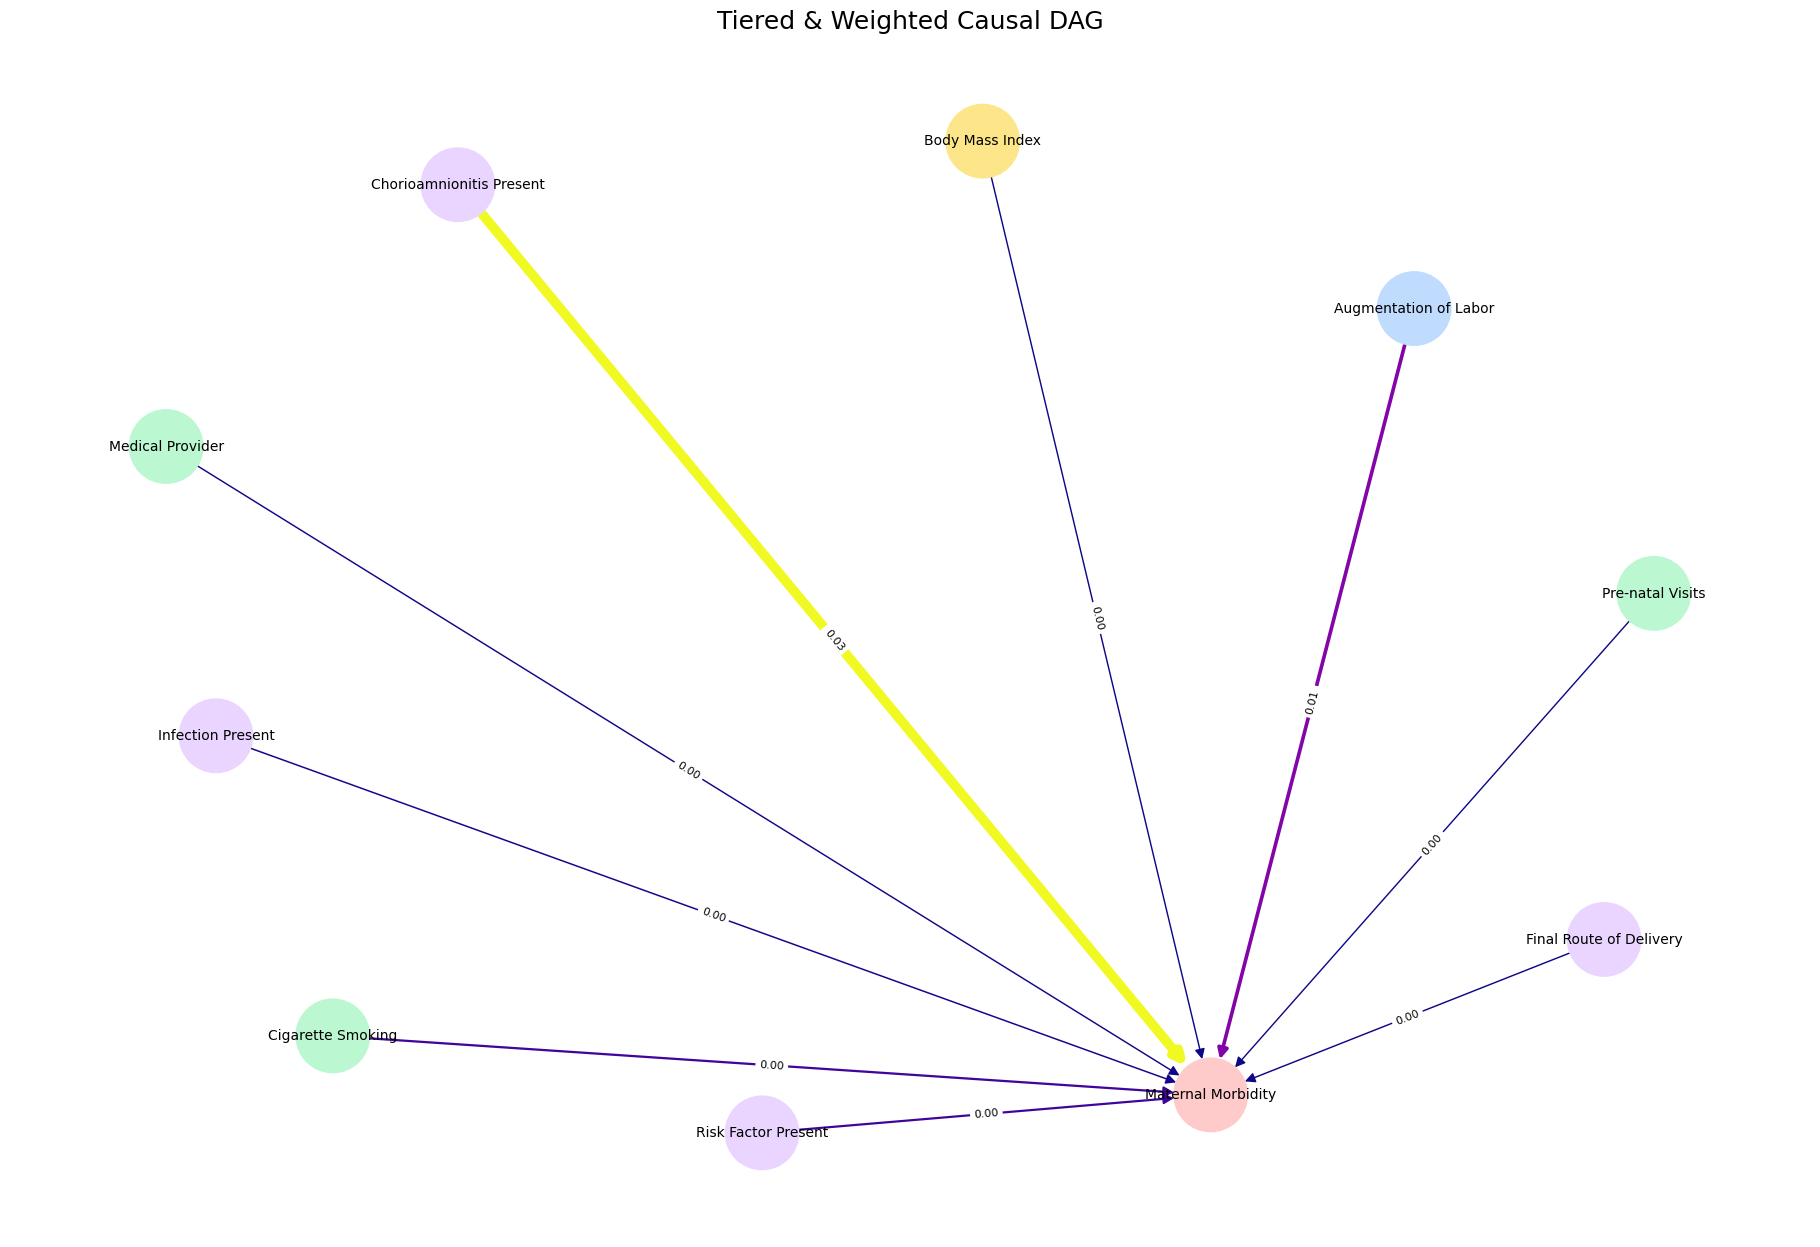

In [24]:
G, tiers = build_dag2()
compute_edge_strengths(G, df)
plot_weighted_dag(G, tiers)